In [15]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import re

# Funzione per estrarre e convertire i valori dell'ottava colonna in liste di float
def get_eight_column_values(df, type_val, module_val, name_val):
    filtered_df = df[(df['type'] == type_val) & (df['module'] == module_val) & (df['name'] == name_val)]
    if filtered_df.empty:
        return None
    values = filtered_df.iloc[:, 7].str.split().apply(lambda x: list(map(float, x)))
    return values.explode().astype(float).values

# Funzione per calcolare l'intervallo di confidenza
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    margin = sem * stats.t.ppf((1 + confidence) / 2, len(data) - 1)
    return mean, mean - margin, mean + margin

# Funzione per rimuovere '_vec' dalla fine del nome del file
def remove_vec_suffix(file_name):
    if file_name.endswith('_vec.csv'):
        return file_name[:-8]
    else:
        return file_name

# Funzione per ottenere il numero finale dal nome del file
def get_file_number(file_name):
    match = re.search(r'\d+$', file_name)
    if match:
        return int(match.group())
    else:
        return 0  # Se non viene trovato nessun numero, restituisci 0

# Funzione per analizzare un singolo file CSV
def analyze_csv(file_path, ignored_files, results):
    df = pd.read_csv(file_path)
    description = df[df['attrname'] == 'description']['attrvalue'].values
    description = description[0] if len(description) > 0 else "N/A"

    is_N = any("N=1" in val for val in df[df['attrname'] == 'description']['attrvalue'].values)

    pDistribution = get_eight_column_values(df, "vector", "TandemQueueSystem.Server", "pDistribution")
    vDistribution = get_eight_column_values(df, "vector", "TandemQueueSystem.Server", "vDistribution")
    lifeTime = get_eight_column_values(df, "vector", "TandemQueueSystem.sink", "lifeTime:vector")

    if pDistribution is None or vDistribution is None or lifeTime is None:
        ignored_files.append((remove_vec_suffix(os.path.basename(file_path)), description))
        return

    min_length = min(len(pDistribution), len(vDistribution), len(lifeTime))
    pDistribution = pDistribution[:min_length]
    vDistribution = vDistribution[:min_length]
    lifeTime = lifeTime[:min_length]

    queueLength_Q1 = get_eight_column_values(df, "vector", "TandemQueueSystem.Q1", "queueLength:vector")
    queueLength_Q2 = get_eight_column_values(df, "vector", "TandemQueueSystem.Q2", "queueLength:vector")

    if is_N:
        queueLength_Q2 = np.zeros(len(queueLength_Q1))
    else: 
        if queueLength_Q1 is None or queueLength_Q2 is None:
                ignored_files.append((remove_vec_suffix(os.path.basename(file_path)), description))
                return

    Cw = 1  # Definisci il valore di Cw

    mean_W, ci_low_W, ci_high_W = confidence_interval(lifeTime)
    U_values = vDistribution - pDistribution - (Cw * lifeTime)
    mean_U, ci_low_U, ci_high_U = confidence_interval(U_values)
    max_W = np.max(lifeTime)
    min_W = np.min(lifeTime)
    mean_max_W, ci_low_max_W, ci_high_max_W = confidence_interval(lifeTime, confidence=0.95)
    mean_min_W, ci_low_min_W, ci_high_min_W = confidence_interval(lifeTime, confidence=0.95)
    utilization_Q1 = queueLength_Q1 / np.sum(queueLength_Q1)
    utilization_Q2 = queueLength_Q2 / np.sum(queueLength_Q2)
    mean_utilization_Q1, ci_low_utilization_Q1, ci_high_utilization_Q1 = confidence_interval(utilization_Q1)
    mean_utilization_Q2, ci_low_utilization_Q2, ci_high_utilization_Q2 = confidence_interval(utilization_Q2)

    results.append({
        "File": remove_vec_suffix(os.path.basename(file_path)),
        "File_Number": get_file_number(remove_vec_suffix(os.path.basename(file_path))),
        "Description": description,
        "mean_W": mean_W,
        "ci_low_W": ci_low_W,
        "ci_high_W": ci_high_W,
        "mean_U": mean_U,
        "ci_low_U": ci_low_U,
        "ci_high_U": ci_high_U,
        "max_W": max_W,
        "ci_low_max_W": ci_low_max_W,
        "ci_high_max_W": ci_high_max_W,
        "min_W": min_W,
        "ci_low_min_W": ci_low_min_W,
        "ci_high_min_W": ci_high_min_W,
        "mean_utilization_Q1": mean_utilization_Q1,
        "ci_low_utilization_Q1": ci_low_utilization_Q1,
        "ci_high_utilization_Q1": ci_high_utilization_Q1,
        "mean_utilization_Q2": mean_utilization_Q2,
        "ci_low_utilization_Q2": ci_low_utilization_Q2,
        "ci_high_utilization_Q2": ci_high_utilization_Q2
    })

# Funzione per analizzare tutti i file CSV in una directory
def analyze_directory(directory_path):
    ignored_files = []
    results = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv') and not file_name.endswith('_sca.csv'):
            file_path = os.path.join(directory_path, file_name)
            analyze_csv(file_path, ignored_files, results)
    
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(by='File_Number')  # Ordina per numero del file
        results_df.drop(columns=['File_Number'], inplace=True)  # Rimuovi la colonna File_Number
        results_df.to_csv(os.path.join('./results_summary_convalidation.csv'), index=False)
    
    if ignored_files:
        ignored_files_sorted = sorted(ignored_files, key=lambda x: get_file_number(x[0]))  # Ordina gli ignorati per numero del file
        ignored_df = pd.DataFrame(ignored_files_sorted, columns=['File', 'Description'])
        ignored_df.to_csv(os.path.join('./ignored_files_convalidation.csv'), index=False)

# Esempio di utilizzo
directory_path = './results_CSV_convalidation'
analyze_directory(directory_path)


Studio Transiente Iniziale

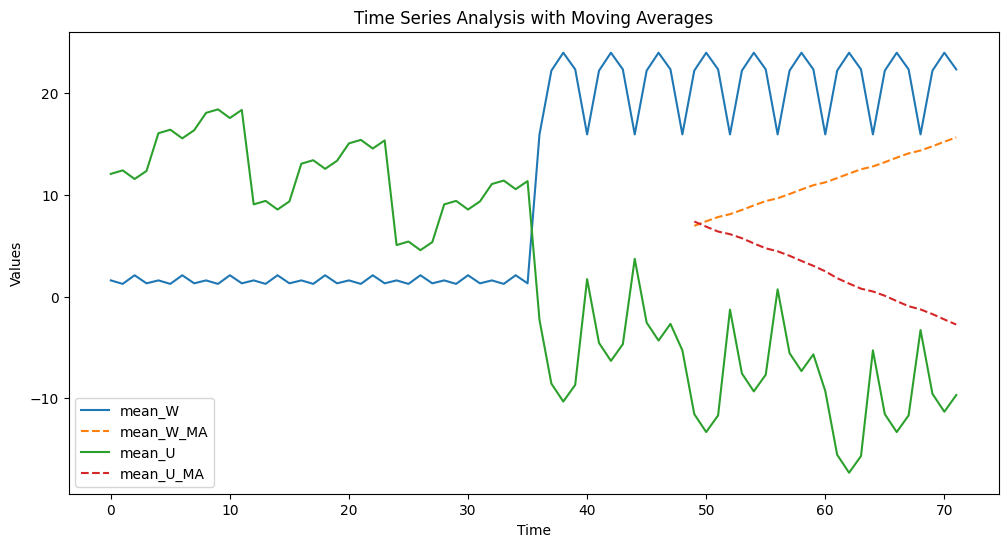

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Funzione per calcolare la media mobile
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

# Funzione per trovare il punto di stabilizzazione
def find_stabilization_point(data):
    window_size = len(data) // 50  # Utilizziamo il 50% della lunghezza dei dati come finestra
    threshold = np.std(data) * 0.05  # Utilizziamo il 5% della deviazione standard come threshold iniziale
    
    for i in range(window_size, len(data)):
        recent_values = data[i-window_size:i]
        if np.max(np.abs(np.diff(recent_values))) < threshold:
            return i
        # Aggiorna il threshold per adeguarsi alla variabilità dei dati
        threshold = np.std(recent_values) * 0.05  # Ricalcoliamo il threshold con la deviazione standard attuale
    
    return len(data)

# Caricare i dati
results_df = pd.read_csv('./results_summary_convalidation.csv')

# Impostare una finestra per la media mobile
window_size = 50

# Calcolare la media mobile
results_df['mean_W_MA'] = moving_average(results_df['mean_W'], window_size)
results_df['mean_U_MA'] = moving_average(results_df['mean_U'], window_size)

# Visualizzare le serie temporali originali e le medie mobili
plt.figure(figsize=(12, 6))
plt.plot(results_df['mean_W'], label='mean_W')
plt.plot(results_df['mean_W_MA'], label='mean_W_MA', linestyle='--')
plt.plot(results_df['mean_U'], label='mean_U')
plt.plot(results_df['mean_U_MA'], label='mean_U_MA', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Time Series Analysis with Moving Averages')
plt.legend()
plt.show()

# Trovare il punto di stabilizzazione per mean_W e mean_U
# stabilization_point_W = find_stabilization_point(results_df['mean_W_MA'])
# stabilization_point_U = find_stabilization_point(results_df['mean_U_MA'])
# stabilization_point = max(stabilization_point_W, stabilization_point_U)

# print(f'Tempo ottimale per considerare il sistema in stato stazionario: {stabilization_point}')

# # Rimuovere i primi punti fino al punto di stabilizzazione
# steady_state_data = results_df.iloc[stabilization_point:]

# # Ricalcolare le statistiche dopo aver rimosso il transiente iniziale
# mean_W_steady_state = np.mean(steady_state_data['mean_W'])
# ci_low_W_steady_state, ci_high_W_steady_state = stats.t.interval(0.95, len(steady_state_data['mean_W'])-1, loc=mean_W_steady_state, scale=stats.sem(steady_state_data['mean_W']))

# mean_U_steady_state = np.mean(steady_state_data['mean_U'])
# ci_low_U_steady_state, ci_high_U_steady_state = stats.t.interval(0.95, len(steady_state_data['mean_U'])-1, loc=mean_U_steady_state, scale=stats.sem(steady_state_data['mean_U']))

# # Visualizzare i risultati
# print(f'Statistiche dopo aver rimosso il transiente iniziale:')
# print(f'mean_W: {mean_W_steady_state}, CI: ({ci_low_W_steady_state}, {ci_high_W_steady_state})')
# print(f'mean_U: {mean_U_steady_state}, CI: ({ci_low_U_steady_state}, {ci_high_U_steady_state})')

# # Visualizzare le serie temporali ricalcolate
# plt.figure(figsize=(12, 6))
# plt.plot(steady_state_data['mean_W'], label='mean_W (steady state)')
# plt.plot(steady_state_data['mean_U'], label='mean_U (steady state)')
# plt.xlabel('Time')
# plt.ylabel('Values')
# plt.title('Time Series Analysis (Steady State)')
# plt.legend()
# plt.show()


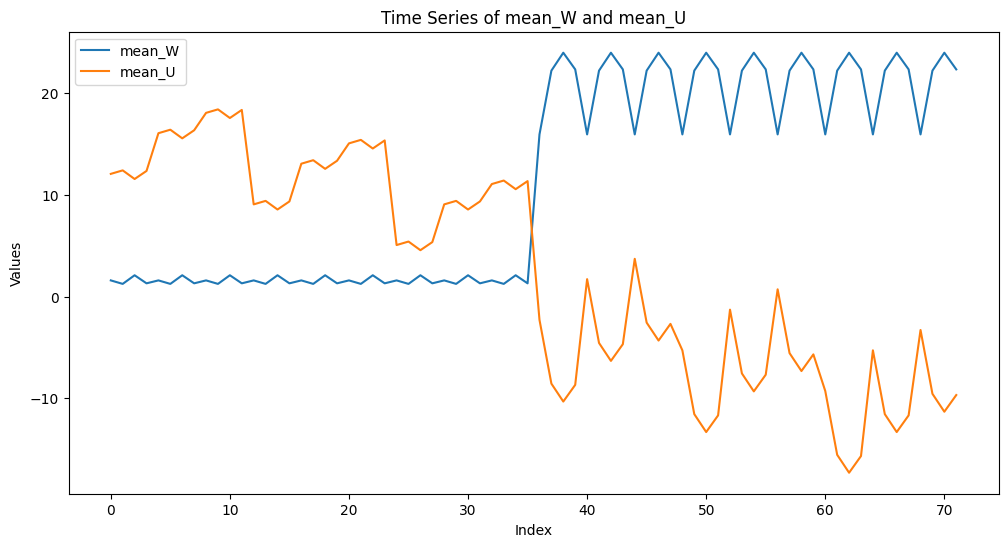

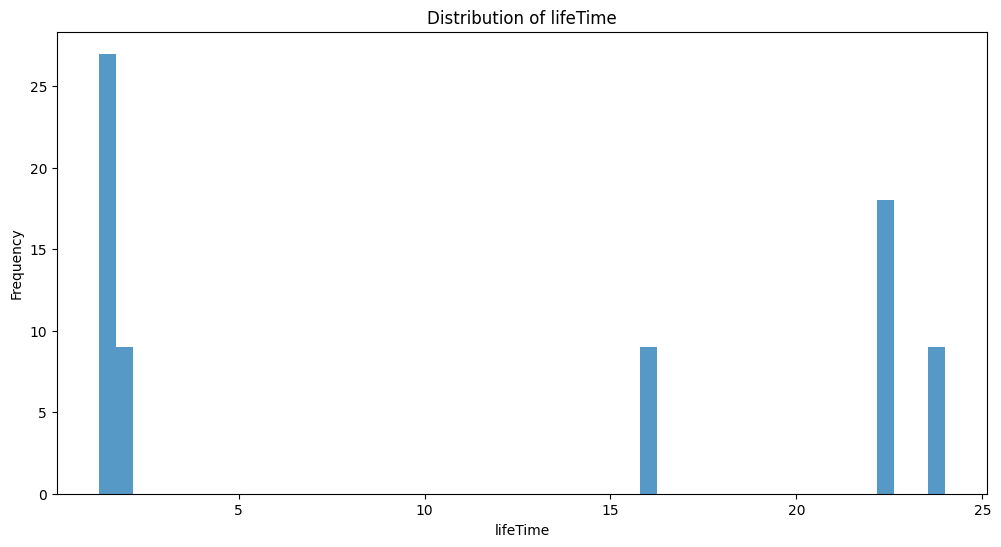

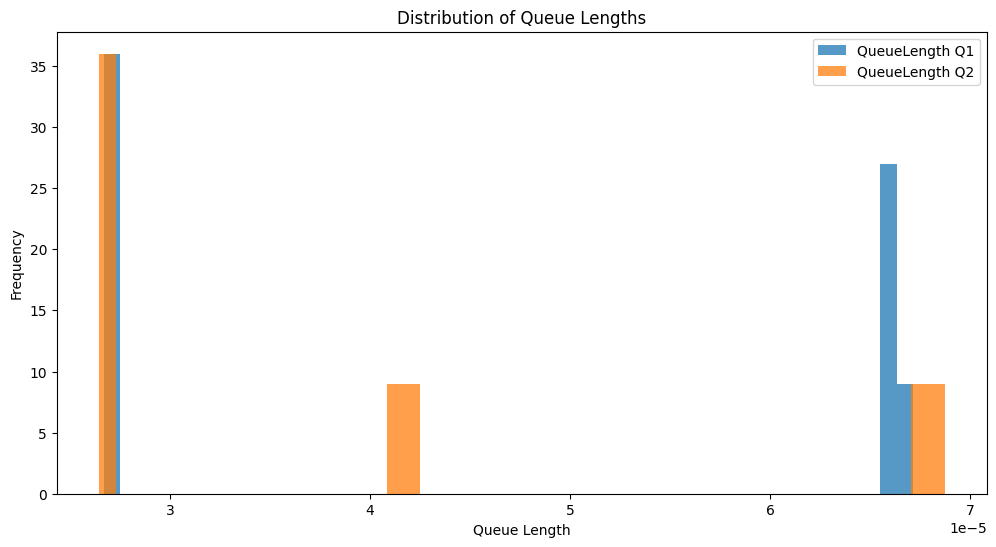

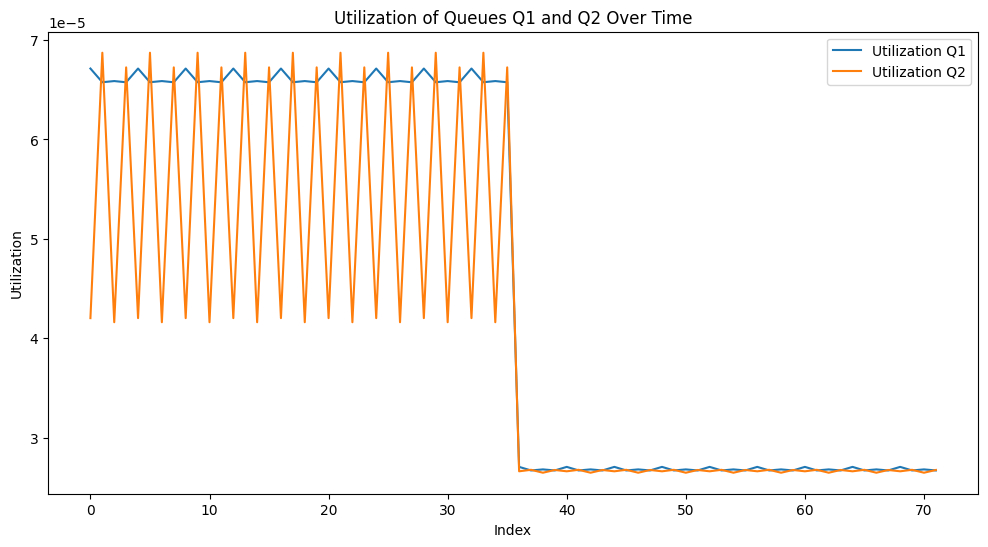

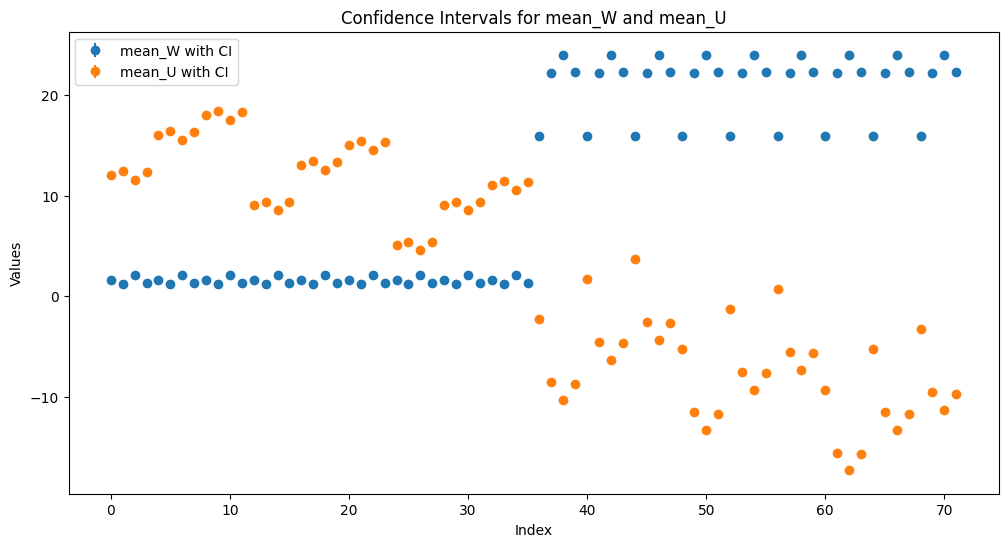

In [17]:
results_df = pd.read_csv('results_summary_convalidation.csv')
# Generare grafici

# Serie temporali di mean_W e mean_U
plt.figure(figsize=(12, 6))
plt.plot(results_df['mean_W'], label='mean_W')
plt.plot(results_df['mean_U'], label='mean_U')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Time Series of mean_W and mean_U')
plt.legend()
plt.show()

# Distribuzione di lifeTime
lifeTime_values = results_df['mean_W']  # Utilizziamo mean_W come proxy per lifeTime
plt.figure(figsize=(12, 6))
plt.hist(lifeTime_values, bins=50, alpha=0.75)
plt.xlabel('lifeTime')
plt.ylabel('Frequency')
plt.title('Distribution of lifeTime')
plt.show()

# Distribuzione di queueLength per Q1 e Q2
queueLength_Q1 = results_df['mean_utilization_Q1']
queueLength_Q2 = results_df['mean_utilization_Q2']

plt.figure(figsize=(12, 6))
plt.hist(queueLength_Q1, bins=50, alpha=0.75, label='QueueLength Q1')
plt.hist(queueLength_Q2, bins=50, alpha=0.75, label='QueueLength Q2')
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.title('Distribution of Queue Lengths')
plt.legend()
plt.show()

# Utilizzo delle code Q1 e Q2 nel tempo
plt.figure(figsize=(12, 6))
plt.plot(results_df['mean_utilization_Q1'], label='Utilization Q1')
plt.plot(results_df['mean_utilization_Q2'], label='Utilization Q2')
plt.xlabel('Index')
plt.ylabel('Utilization')
plt.title('Utilization of Queues Q1 and Q2 Over Time')
plt.legend()
plt.show()

# Intervalli di confidenza per mean_W e mean_U
plt.figure(figsize=(12, 6))
plt.errorbar(range(len(results_df)), results_df['mean_W'], 
             yerr=[results_df['mean_W'] - results_df['ci_low_W'], results_df['ci_high_W'] - results_df['mean_W']], 
             fmt='o', label='mean_W with CI')
plt.errorbar(range(len(results_df)), results_df['mean_U'], 
             yerr=[results_df['mean_U'] - results_df['ci_low_U'], results_df['ci_high_U'] - results_df['mean_U']], 
             fmt='o', label='mean_U with CI')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Confidence Intervals for mean_W and mean_U')
plt.legend()
plt.show()


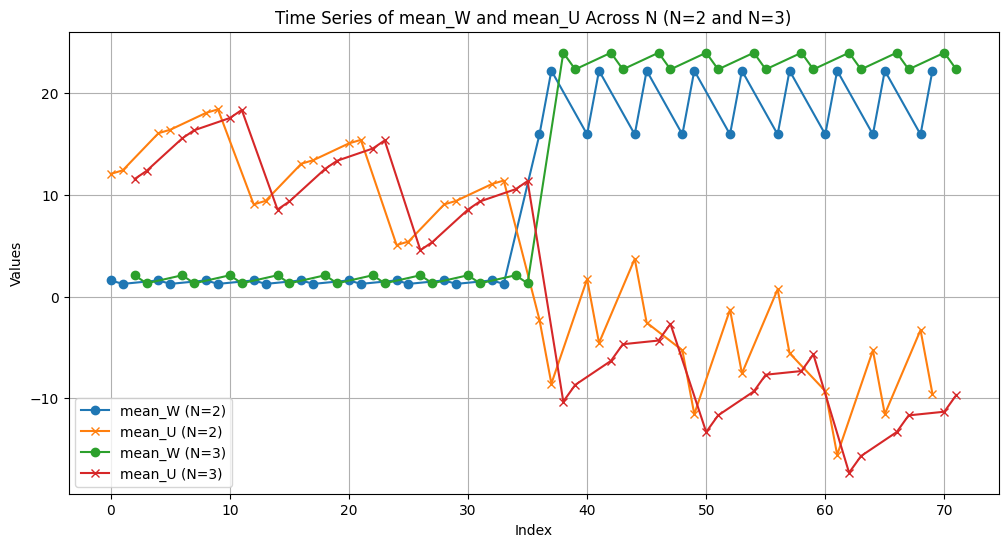

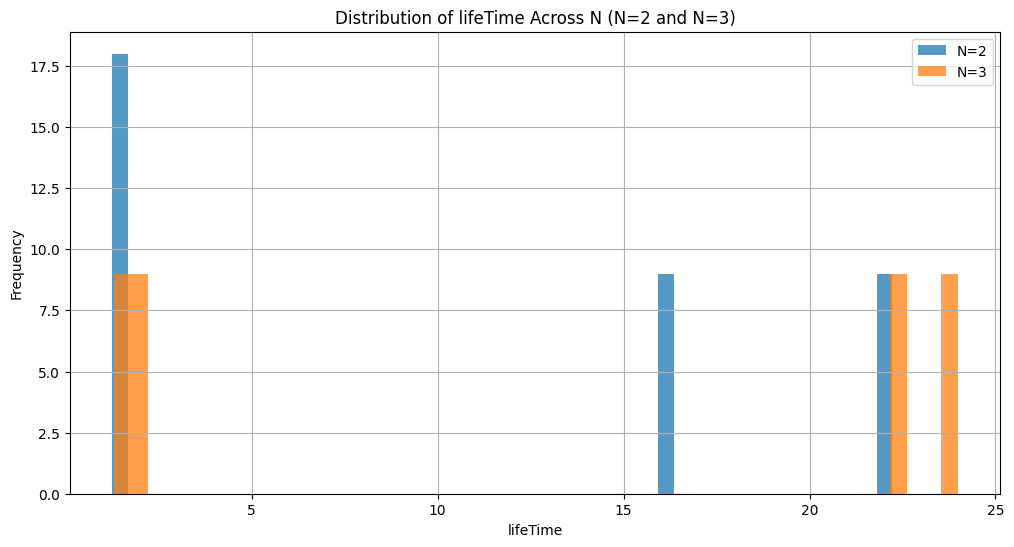

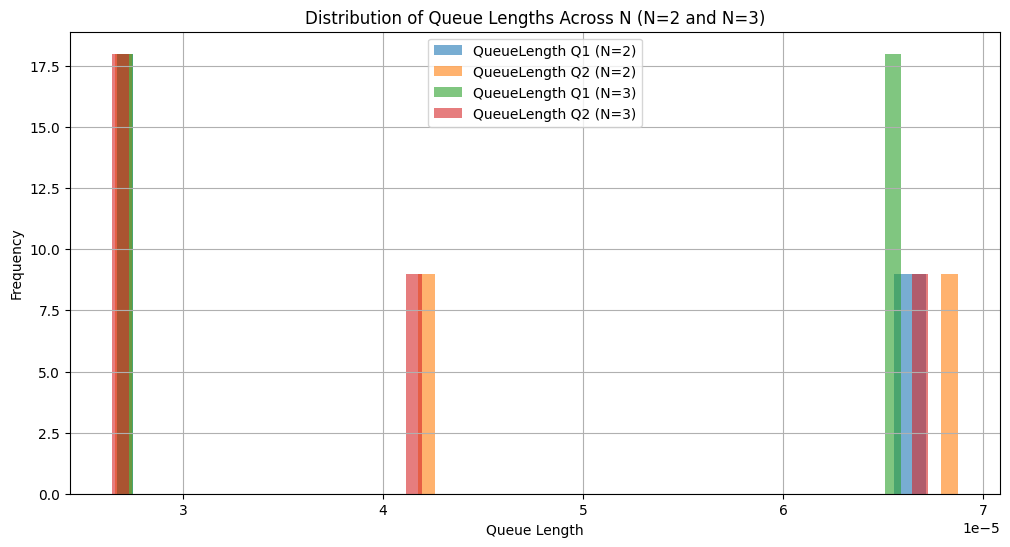

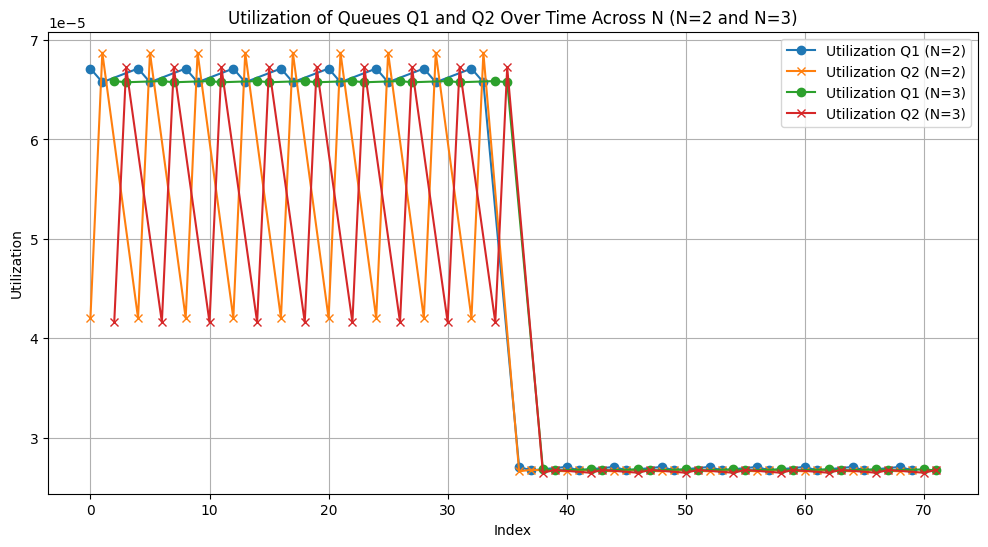

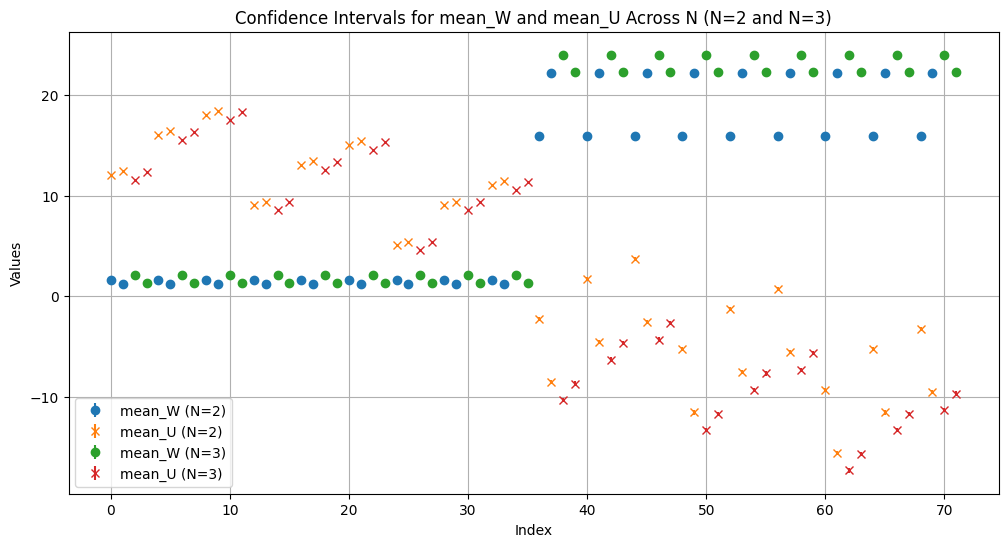

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i dati da results_summary_convalidation.csv
results_df = pd.read_csv('results_summary_convalidation.csv')

# Filtra i dati includendo solo le configurazioni con N=2 e N=3 nella descrizione
results_df = results_df[results_df['Description'].str.contains('N=2|N=3')]

# Estrai i valori di N
results_df['N_value'] = results_df['Description'].str.extract(r'N=(\d+)').astype(int)

# Prepara i grafici

# Grafico: Serie temporali di mean_W e mean_U
plt.figure(figsize=(12, 6))
for n in [2, 3]:
    subset = results_df[results_df['N_value'] == n]
    plt.plot(subset.index, subset['mean_W'], label=f'mean_W (N={n})', marker='o')
    plt.plot(subset.index, subset['mean_U'], label=f'mean_U (N={n})', marker='x')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Time Series of mean_W and mean_U Across N (N=2 and N=3)')
plt.legend()
plt.grid(True)
plt.show()

# Grafico: Distribuzione di lifeTime (utilizziamo mean_W come proxy per lifeTime)
plt.figure(figsize=(12, 6))
for n in [2, 3]:
    subset = results_df[results_df['N_value'] == n]
    plt.hist(subset['mean_W'], bins=50, alpha=0.75, label=f'N={n}')
plt.xlabel('lifeTime')
plt.ylabel('Frequency')
plt.title('Distribution of lifeTime Across N (N=2 and N=3)')
plt.legend()
plt.grid(True)
plt.show()

# Grafico: Distribuzione di queueLength per Q1 e Q2
plt.figure(figsize=(12, 6))
for n in [2, 3]:
    subset_Q1 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q1'].notnull())]
    subset_Q2 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q2'].notnull())]
    plt.hist(subset_Q1['mean_utilization_Q1'], bins=50, alpha=0.6, label=f'QueueLength Q1 (N={n})')
    plt.hist(subset_Q2['mean_utilization_Q2'], bins=50, alpha=0.6, label=f'QueueLength Q2 (N={n})')
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.title('Distribution of Queue Lengths Across N (N=2 and N=3)')
plt.legend()
plt.grid(True)
plt.show()

# Grafico: Utilizzo delle code Q1 e Q2 nel tempo
plt.figure(figsize=(12, 6))
for n in [2, 3]:
    subset_Q1 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q1'].notnull())]
    subset_Q2 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q2'].notnull())]
    plt.plot(subset_Q1.index, subset_Q1['mean_utilization_Q1'], label=f'Utilization Q1 (N={n})', marker='o')
    plt.plot(subset_Q2.index, subset_Q2['mean_utilization_Q2'], label=f'Utilization Q2 (N={n})', marker='x')
plt.xlabel('Index')
plt.ylabel('Utilization')
plt.title('Utilization of Queues Q1 and Q2 Over Time Across N (N=2 and N=3)')
plt.legend()
plt.grid(True)
plt.show()

# Grafico: Intervalli di confidenza per mean_W e mean_U
plt.figure(figsize=(12, 6))
for n in [2, 3]:
    subset = results_df[results_df['N_value'] == n]
    plt.errorbar(subset.index, subset['mean_W'], 
                 yerr=[subset['mean_W'] - subset['ci_low_W'], subset['ci_high_W'] - subset['mean_W']], 
                 fmt='o', label=f'mean_W (N={n})')
    plt.errorbar(subset.index, subset['mean_U'], 
                 yerr=[subset['mean_U'] - subset['ci_low_U'], subset['ci_high_U'] - subset['mean_U']], 
                 fmt='x', label=f'mean_U (N={n})')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Confidence Intervals for mean_W and mean_U Across N (N=2 and N=3)')
plt.legend()
plt.grid(True)
plt.show()


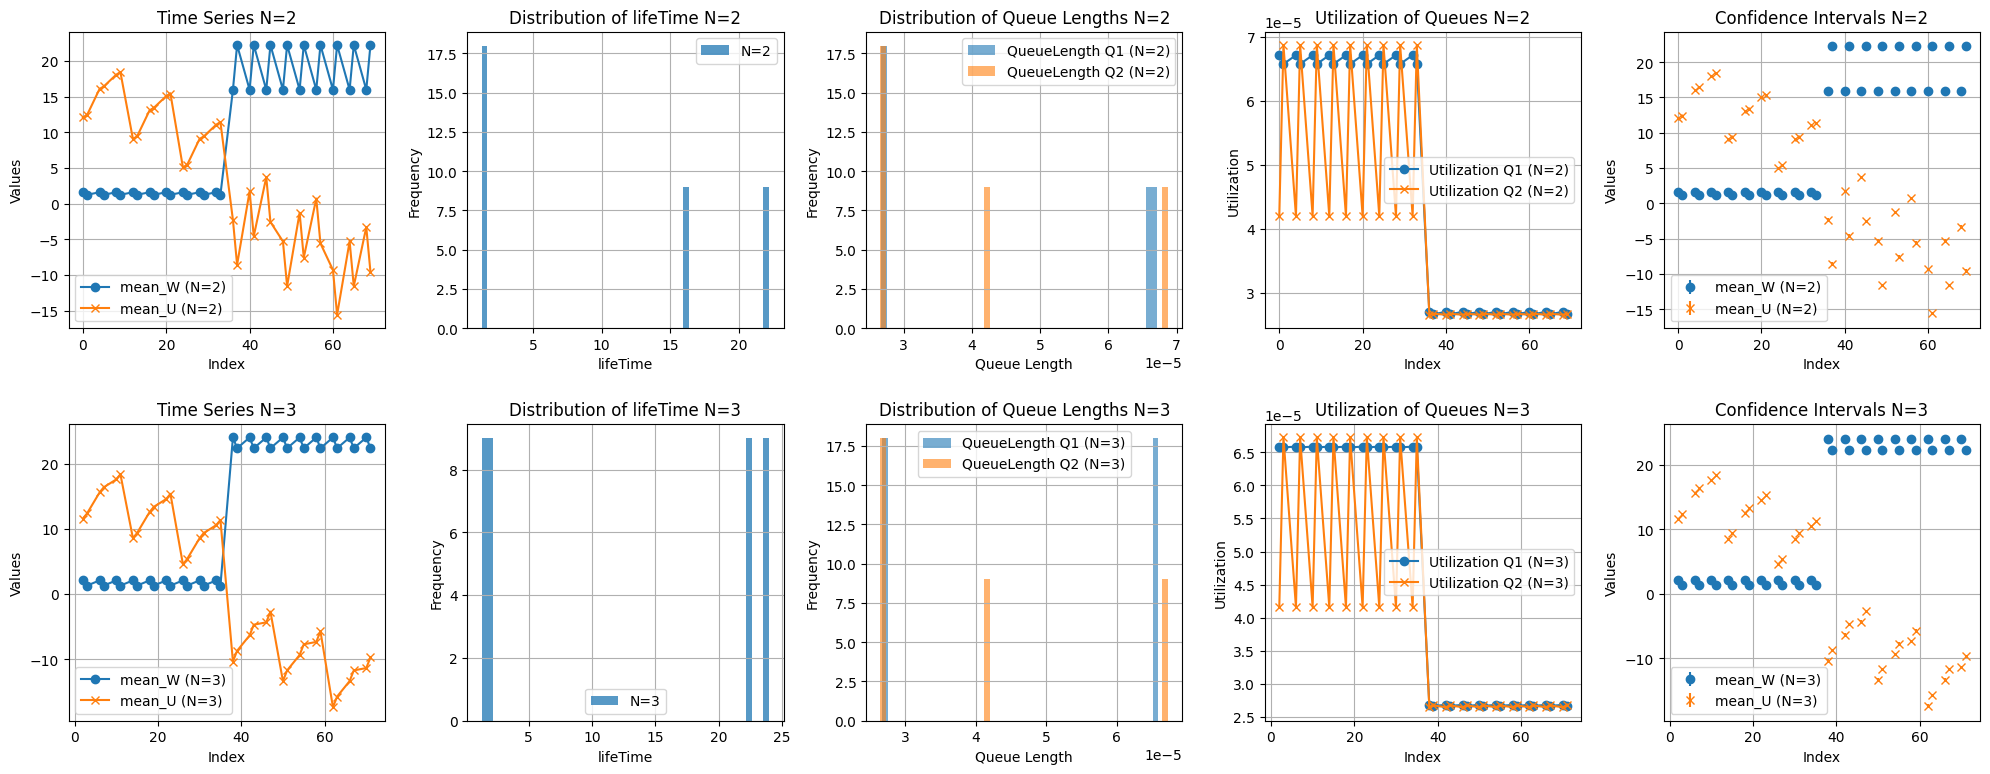

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i dati da results_summary.csv
results_df = pd.read_csv('results_summary_convalidation.csv')

# Filtra i dati includendo solo le configurazioni con N=2 e N=3 nella descrizione
results_df = results_df[results_df['Description'].str.contains('N=')]
results_df = results_df[results_df['Description'].str.contains('N=2') | results_df['Description'].str.contains('N=3')]

# Estrai i valori di N
results_df['N_value'] = results_df['Description'].str.extract(r'N=(\d+)').astype(int)

# Prepara i grafici

# Creazione della griglia di subplot 2x5
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

# Lista dei valori di N
N_values = [2, 3]

# Grafico 1: Serie temporali di mean_W e mean_U
for i, n in enumerate(N_values):
    subset = results_df[results_df['N_value'] == n]
    axs[i, 0].plot(subset.index, subset['mean_W'], label=f'mean_W (N={n})', marker='o')
    axs[i, 0].plot(subset.index, subset['mean_U'], label=f'mean_U (N={n})', marker='x')
    axs[i, 0].set_xlabel('Index')
    axs[i, 0].set_ylabel('Values')
    axs[i, 0].set_title(f'Time Series N={n}')
    axs[i, 0].legend()
    axs[i, 0].grid(True)

# Grafico 2: Distribuzione di lifeTime (mean_W come proxy)
for i, n in enumerate(N_values):
    subset = results_df[results_df['N_value'] == n]
    axs[i, 1].hist(subset['mean_W'], bins=50, alpha=0.75, label=f'N={n}')
    axs[i, 1].set_xlabel('lifeTime')
    axs[i, 1].set_ylabel('Frequency')
    axs[i, 1].set_title(f'Distribution of lifeTime N={n}')
    axs[i, 1].legend()
    axs[i, 1].grid(True)

# Grafico 3: Distribuzione di queueLength per Q1 e Q2
for i, n in enumerate(N_values):
    subset_Q1 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q1'].notnull())]
    subset_Q2 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q2'].notnull())]
    axs[i, 2].hist(subset_Q1['mean_utilization_Q1'], bins=50, alpha=0.6, label=f'QueueLength Q1 (N={n})')
    if n != 1:
        axs[i, 2].hist(subset_Q2['mean_utilization_Q2'], bins=50, alpha=0.6, label=f'QueueLength Q2 (N={n})')
    axs[i, 2].set_xlabel('Queue Length')
    axs[i, 2].set_ylabel('Frequency')
    axs[i, 2].set_title(f'Distribution of Queue Lengths N={n}')
    axs[i, 2].legend()
    axs[i, 2].grid(True)
    axs[i, 2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Grafico 4: Utilizzo delle code Q1 e Q2 nel tempo
for i, n in enumerate(N_values):
    subset_Q1 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q1'].notnull())]
    subset_Q2 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q2'].notnull())]
    axs[i, 3].plot(subset_Q1.index, subset_Q1['mean_utilization_Q1'], label=f'Utilization Q1 (N={n})', marker='o')
    axs[i, 3].plot(subset_Q2.index, subset_Q2['mean_utilization_Q2'], label=f'Utilization Q2 (N={n})', marker='x')
    axs[i, 3].set_xlabel('Index')
    axs[i, 3].set_ylabel('Utilization')
    axs[i, 3].set_title(f'Utilization of Queues N={n}')
    axs[i, 3].legend()
    axs[i, 3].grid(True)
    axs[i, 3].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Grafico 5: Intervalli di confidenza per mean_W e mean_U
for i, n in enumerate(N_values):
    subset = results_df[results_df['N_value'] == n]
    axs[i, 4].errorbar(subset.index, subset['mean_W'], 
                       yerr=[subset['mean_W'] - subset['ci_low_W'], subset['ci_high_W'] - subset['mean_W']], 
                       fmt='o', label=f'mean_W (N={n})')
    axs[i, 4].errorbar(subset.index, subset['mean_U'], 
                       yerr=[subset['mean_U'] - subset['ci_low_U'], subset['ci_high_U'] - subset['mean_U']], 
                       fmt='x', label=f'mean_U (N={n})')
    axs[i, 4].set_xlabel('Index')
    axs[i, 4].set_ylabel('Values')
    axs[i, 4].set_title(f'Confidence Intervals N={n}')
    axs[i, 4].legend()
    axs[i, 4].grid(True)

# Regolazione degli spazi tra i subplot per una migliore visualizzazione
plt.tight_layout()
plt.show()


        File  N_value   Strategy  lambda     mean_W  L_observed  \
0    Config1        2    Exact_N    1.25   1.594721    0.000109   
1    Config2        2  Limited_N    1.25   1.250708    0.000134   
2    Config3        3    Exact_N    1.25   2.100161    0.000107   
3    Config4        3  Limited_N    1.25   1.306267    0.000133   
4    Config5        2    Exact_N    1.25   1.594721    0.000109   
..       ...      ...        ...     ...        ...         ...   
67  Config68        3  Limited_N    2.00  22.347252    0.000053   
68  Config69        2    Exact_N    2.00  15.950339    0.000054   
69  Config70        2  Limited_N    2.00  22.223818    0.000053   
70  Config71        3    Exact_N    2.00  23.986172    0.000053   
71  Config72        3  Limited_N    2.00  22.347252    0.000053   

    L_theoretical  little_verification  
0        1.993401                False  
1        1.563385                False  
2        2.625201                False  
3        1.632834              

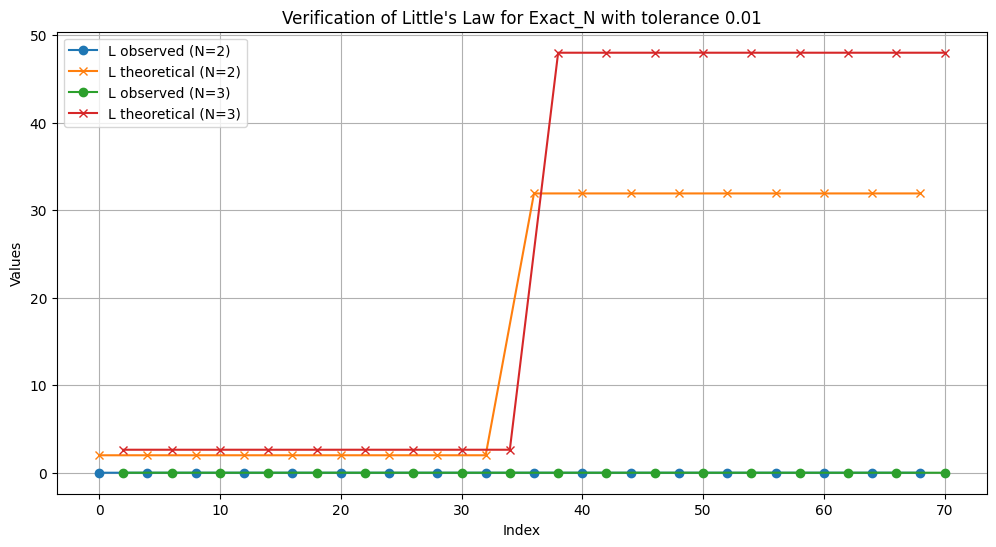

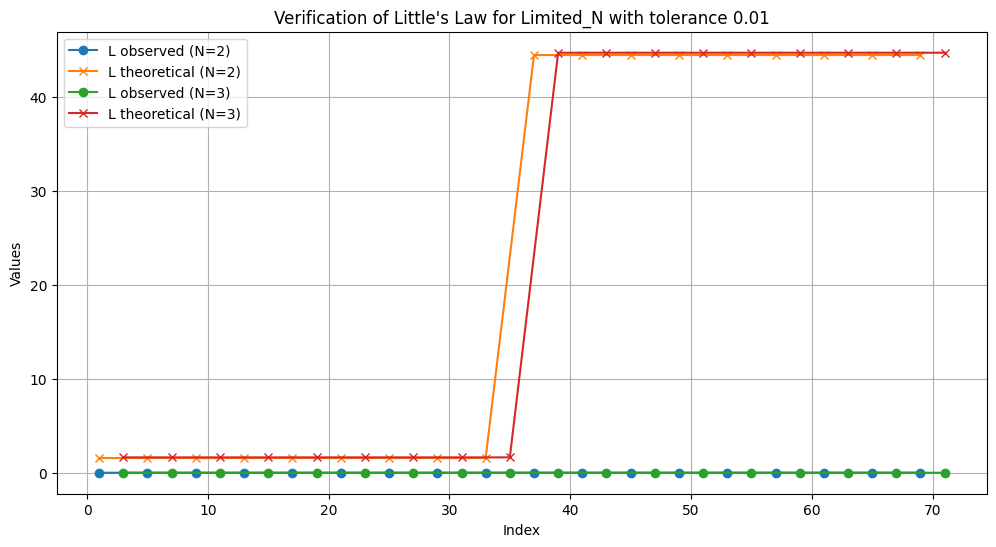

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Funzione per estrarre il valore di lambda dalla descrizione
def extract_lambda(description):
    match = re.search(r'lambda=([\d\.]+)', description)
    if match:
        return float(match.group(1))
    else:
        return None

# Carica i dati da results_summary_convalidation.csv
results_df = pd.read_csv('results_summary_convalidation.csv')

# Filtra i dati includendo solo le configurazioni con N=2 e N=3 nella descrizione
results_df = results_df[results_df['Description'].str.contains('N=2|N=3')]

# Estrai i valori di N
results_df['N_value'] = results_df['Description'].str.extract(r'N=(\d+)').astype(int)

# Determina la strategia dalla descrizione
results_df['Strategy'] = results_df['Description'].apply(lambda desc: 'Exact_N' if 'Strategy=0' in desc else 'Limited_N')

# Estrai i valori di lambda dalla descrizione
results_df['lambda'] = results_df['Description'].apply(extract_lambda)

# Calcola le colonne L osservato e L teorico
results_df['L_observed'] = results_df['mean_utilization_Q1'] + results_df['mean_utilization_Q2']
results_df['L_theoretical'] = results_df['lambda'] * results_df['mean_W']

# Verifica del teorema di Little con tolleranza
tolerance = 0.01
results_df['little_verification'] = results_df.apply(lambda row: abs(row['L_observed'] - row['L_theoretical']) < tolerance, axis=1)

# Salva i risultati in un file CSV
results_df.to_csv('LittleLaw_results.csv', index=False)

# Mostra i risultati per debug
print(results_df[['File', 'N_value', 'Strategy', 'lambda', 'mean_W', 'L_observed', 'L_theoretical', 'little_verification']])

# Grafico per verificare il teorema di Little per ciascuna strategia
for strategy in results_df['Strategy'].unique():
    plt.figure(figsize=(12, 6))
    for n in [2, 3]:
        subset = results_df[(results_df['N_value'] == n) & (results_df['Strategy'] == strategy)]
        plt.plot(subset.index, subset['L_observed'], label=f'L observed (N={n})', marker='o')
        plt.plot(subset.index, subset['L_theoretical'], label=f'L theoretical (N={n})', marker='x')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Verification of Little\'s Law for {strategy} with tolerance {tolerance}')
    plt.legend()
    plt.grid(True)
    plt.show()


General lambda: 2.3245811433536587e-06
        File  N_value   Strategy     mean_W  L_observed  \
0    Config1        2    Exact_N   1.594721    0.000109   
1    Config2        2  Limited_N   1.250708    0.000134   
2    Config3        3    Exact_N   2.100161    0.000107   
3    Config4        3  Limited_N   1.306267    0.000133   
4    Config5        2    Exact_N   1.594721    0.000109   
..       ...      ...        ...        ...         ...   
67  Config68        3  Limited_N  22.347252    0.000053   
68  Config69        2    Exact_N  15.950339    0.000054   
69  Config70        2  Limited_N  22.223818    0.000053   
70  Config71        3    Exact_N  23.986172    0.000053   
71  Config72        3  Limited_N  22.347252    0.000053   

    L_theoretical_general  little_verification_general  
0                0.000004                         True  
1                0.000003                         True  
2                0.000005                         True  
3                0.00000

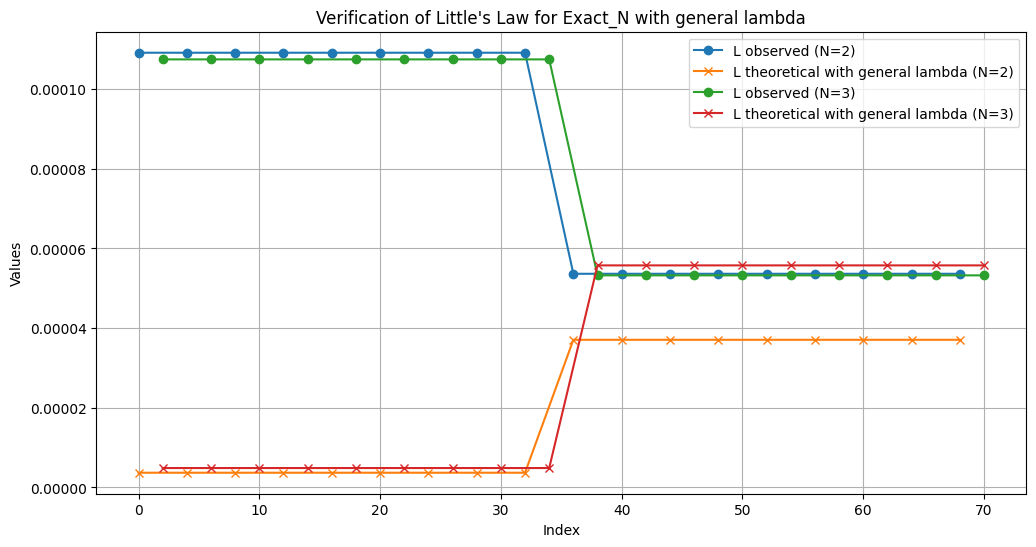

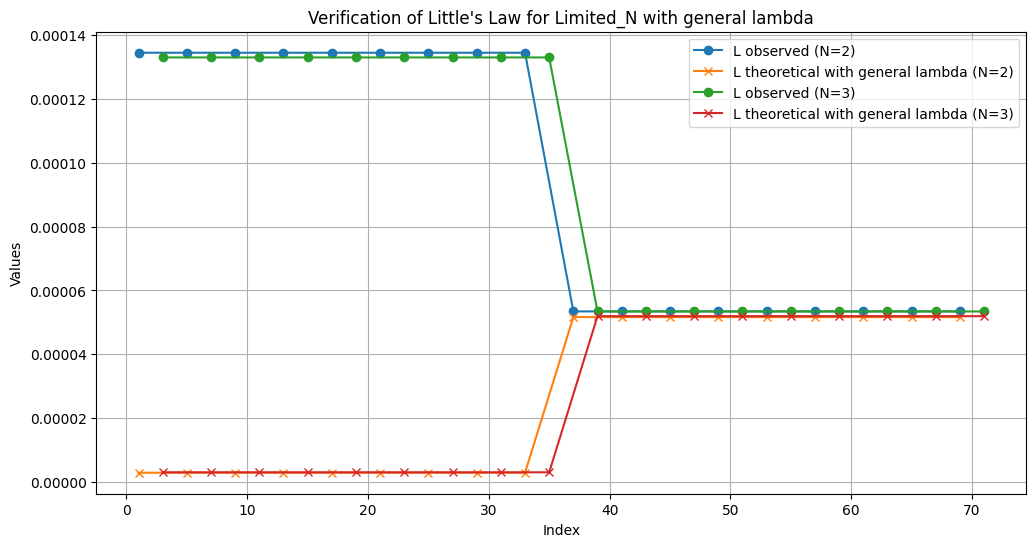

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.optimize import minimize

# Funzione per estrarre il valore di lambda dalla descrizione
def extract_lambda(description):
    match = re.search(r'lambda=([\d\.]+)', description)
    if match:
        return float(match.group(1))
    else:
        return None

# Funzione obiettivo generale per minimizzare la somma delle differenze tra L osservato e L teorico su tutte le simulazioni
def general_objective_function(lambda_val, mean_W, L_observed):
    L_theoretical = lambda_val * mean_W
    return np.sum(np.abs(L_theoretical - L_observed))

# Carica i dati da results_summary_convalidation.csv
results_df = pd.read_csv('results_summary_convalidation.csv')

# Filtra i dati includendo solo le configurazioni con N=2 e N=3 nella descrizione
results_df = results_df[results_df['Description'].str.contains('N=2|N=3')]

# Estrai i valori di N
results_df['N_value'] = results_df['Description'].str.extract(r'N=(\d+)').astype(int)

# Determina la strategia dalla descrizione
results_df['Strategy'] = results_df['Description'].apply(lambda desc: 'Exact_N' if 'Strategy=0' in desc else 'Limited_N')

# Estrai i valori di lambda dalla descrizione
results_df['lambda'] = results_df['Description'].apply(extract_lambda)

# Calcola la colonna L osservato
results_df['L_observed'] = results_df['mean_utilization_Q1'] + results_df['mean_utilization_Q2']

# Array di mean_W e L_observed per tutte le simulazioni
mean_W_all = results_df['mean_W'].values
L_observed_all = results_df['L_observed'].values

# Ottimizzazione per trovare il valore generale di lambda
result = minimize(general_objective_function, np.mean(results_df['lambda']), args=(mean_W_all, L_observed_all), method='Nelder-Mead')
general_lambda = result.x[0]

# Calcola L teorico con lambda generale
results_df['L_theoretical_general'] = general_lambda * results_df['mean_W']

# Verifica del teorema di Little con lambda generale
tolerance = 0.01
results_df['little_verification_general'] = results_df.apply(lambda row: abs(row['L_observed'] - row['L_theoretical_general']) < tolerance, axis=1)

# Salva i risultati in un file CSV
results_df.to_csv('LittleLaw_general_lambda_results.csv', index=False)

# Mostra i risultati per debug
print(f"General lambda: {general_lambda}")
print(results_df[['File', 'N_value', 'Strategy', 'mean_W', 'L_observed', 'L_theoretical_general', 'little_verification_general']])

# Grafico per verificare il teorema di Little per ciascuna strategia con lambda generale
for strategy in results_df['Strategy'].unique():
    plt.figure(figsize=(12, 6))
    for n in [2, 3]:
        subset = results_df[(results_df['N_value'] == n) & (results_df['Strategy'] == strategy)]
        plt.plot(subset.index, subset['L_observed'], label=f'L observed (N={n})', marker='o')
        plt.plot(subset.index, subset['L_theoretical_general'], label=f'L theoretical with general lambda (N={n})', marker='x')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Verification of Little\'s Law for {strategy} with general lambda')
    plt.legend()
    plt.grid(True)
    plt.show()
